In [37]:
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
from scipy.spatial.distance import cosine

import matplotlib.pyplot as plt


from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import torch
from torch import nn
from torch import optim

# Building the Dataset 

In [19]:
class SimilarImagesDataset(Dataset):

    def __init__(self, im_path, transform=None):
        self.path = im_path 
        self.files = self.absolute_file_paths(self.path)
        self.transform = transform
        
    def absolute_file_paths(self, directory):
        path = os.path.abspath(directory)
        return [entry.path for entry in os.scandir(path) if entry.is_file()]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):

        img_path = self.files[idx]
        #print(img_path)
        image = Image.open(img_path).convert("RGB")
        image = image.resize((512,512))

        if self.transform is not None:
            tensor_image = self.transform(image)
            return tensor_image, tensor_image
        
        return image

# Building the model

In [4]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_c, out_c, kernel, padding = 0):
        super().__init__()

        self.conv = nn.Conv2d(in_c, out_c, kernel, padding = padding)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2,2))

    def forward(self, input):

        x = self.conv(input)
        x = self.relu(x)
        x = self.maxpool(x)

        return x


class DeConvBlock(nn.Module):

    def __init__(self, in_c, out_c, kernel, stride = 1):
        super().__init__()

        self.deconv = nn.ConvTranspose2d(in_c, out_c, kernel, stride = stride)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, input):

        x = self.deconv(input)
        x = self.relu(x)

        return x



class IMEncoder(nn.Module):

    def __init__(self, in_c, kernel, padding = 0):
        super().__init__()

        self.convB1 = ConvBlock(in_c, 16, kernel, padding)
        self.convB2 = ConvBlock(16, 32, kernel, padding)
        self.convB3 = ConvBlock(32, 64, kernel, padding)
        self.convB4 = ConvBlock(64, 128, kernel, padding)

    def forward(self, input):

        x = self.convB1(input)
        x = self.convB2(x)
        x = self.convB3(x)
        x = self.convB4(x)

        return x


class IMDecoder(nn.Module):

    def __init__(self, out_c, kernel, stride = 1):
        super().__init__()

        self.deconvB1 = DeConvBlock(128, 64, kernel, stride)
        self.deconvB2 = DeConvBlock(64, 32, kernel, stride)
        self.deconvB3 = DeConvBlock(32, 16, kernel, stride)
        self.deconvB4 = DeConvBlock(16, out_c, kernel, stride)

    def forward(self, input):

        x = self.deconvB1(input)
        x = self.deconvB2(x)
        x = self.deconvB3(x)
        x = self.deconvB4(x)

        return x


# AutoEncoder training
Training and saving features for the sample images

In [5]:
def train_step(encoder, decoder, train_loader, lossfn, opt, device):
    encoder.train()
    decoder.train()

    for batch_idx, (train_img, target_img) in enumerate(train_loader):

        train_img = train_img.to(device)
        target_img = target_img.to(device)
        
        opt.zero_grad()

        enc_output = encoder(train_img)
        dec_output = decoder(enc_output)
        
        loss = lossfn(dec_output, target_img)
        loss.backward()
        print(f"train itr {batch_idx} ... loss {loss}")

        opt.step()

    return loss.item()

def validation_step(encoder, decoder, val_loader, lossfn, device):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        for batch_idx, (val_img, target_img) in enumerate(val_loader):
            val_img = val_img.to(device)
            target_img = target_img.to(device)

            enc_output = encoder(val_img)
            dec_output = decoder(enc_output)

            loss = lossfn(dec_output, target_img)
            print(f"val itr {batch_idx} ... loss {loss}")

    return loss.item()

In [6]:
# Run the training on GPU
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

# Normalize and convert to tensor
transforms = T.Compose([T.ToTensor()])

# Load the dataset
data = SimilarImagesDataset('image_similarity_examples/', transform=transforms)
print(data.__len__())

# Train - val split
train_data, val_data = torch.utils.data.random_split(data, [3, 1]) 
train_loader = DataLoader(train_data, batch_size=1)
val_loader = DataLoader(val_data, batch_size=1)

loss_fn = nn.MSELoss()

# model
encoder = IMEncoder(in_c=3, kernel=(3, 3), padding=(1, 1))
decoder = IMDecoder(out_c=3, kernel=(2, 2), stride=(2, 2))

encoder.to(device)
decoder.to(device)

# optimizer
autoencoder_params = list(encoder.parameters()) + list(decoder.parameters())
opt = optim.Adam(autoencoder_params, lr=1e-3)

4


In [7]:
# train
epochs = 10
max_loss = 9999999

for epoch in tqdm(range(epochs)):
    
    train_loss = train_step(encoder, decoder, train_loader, loss_fn, opt, device)
    val_loss = validation_step(encoder, decoder, train_loader, loss_fn, device)
    
    print("Epoch {} || Training Loss {} || Val Loss {}".format(
        epoch, train_loss, val_loss))
    
    # save best model
    if val_loss < max_loss:
        max_loss = val_loss
        print("Validation Loss decreased, saving new best model")
        torch.save(encoder.state_dict(), "encoder_model.pt")
        torch.save(decoder.state_dict(), "decoder_model.pt")


 10%|█         | 1/10 [00:00<00:03,  2.28it/s]

train itr 0 ... loss 0.006492344196885824
train itr 1 ... loss 0.040794022381305695
train itr 2 ... loss 0.003131850389763713
val itr 0 ... loss 0.006485415156930685
val itr 1 ... loss 0.0407278873026371
val itr 2 ... loss 0.003133344231173396
Epoch 0 || Training Loss 0.003131850389763713 || Val Loss 0.003133344231173396
Validation Loss decreased, saving new best model


 20%|██        | 2/10 [00:00<00:02,  3.48it/s]

train itr 0 ... loss 0.006485415156930685
train itr 1 ... loss 0.04070150852203369
train itr 2 ... loss 0.003139430657029152
val itr 0 ... loss 0.006487390026450157
val itr 1 ... loss 0.040635835379362106
val itr 2 ... loss 0.003143620677292347
Epoch 1 || Training Loss 0.003139430657029152 || Val Loss 0.003143620677292347
train itr 0 ... loss 0.006487390026450157


 30%|███       | 3/10 [00:00<00:01,  4.19it/s]

train itr 1 ... loss 0.04061102122068405
train itr 2 ... loss 0.0031548738479614258
val itr 0 ... loss 0.006496314890682697
val itr 1 ... loss 0.04054124653339386
val itr 2 ... loss 0.003161207539960742
Epoch 2 || Training Loss 0.0031548738479614258 || Val Loss 0.003161207539960742
train itr 0 ... loss 0.006496314890682697
train itr 1 ... loss 0.04051327705383301


 40%|████      | 4/10 [00:00<00:01,  4.62it/s]

train itr 2 ... loss 0.0031769201159477234
val itr 0 ... loss 0.006510572507977486
val itr 1 ... loss 0.040425531566143036
val itr 2 ... loss 0.0031849807128310204
Epoch 3 || Training Loss 0.0031769201159477234 || Val Loss 0.0031849807128310204
train itr 0 ... loss 0.006510572507977486
train itr 1 ... loss 0.04039087891578674
train itr 2 ... loss 0.003203581552952528


 50%|█████     | 5/10 [00:01<00:01,  4.83it/s]

val itr 0 ... loss 0.006527901627123356
val itr 1 ... loss 0.04026513546705246
val itr 2 ... loss 0.003212427254766226
Epoch 4 || Training Loss 0.003203581552952528 || Val Loss 0.003212427254766226
train itr 0 ... loss 0.006527901627123356
train itr 1 ... loss 0.04021589457988739
train itr 2 ... loss 0.0032328262459486723
val itr 0 ... loss 0.006547792814671993


 60%|██████    | 6/10 [00:01<00:00,  4.98it/s]

val itr 1 ... loss 0.04002545773983002
val itr 2 ... loss 0.0032423511147499084
Epoch 5 || Training Loss 0.0032328262459486723 || Val Loss 0.0032423511147499084
train itr 0 ... loss 0.006547792814671993
train itr 1 ... loss 0.03995960205793381
train itr 2 ... loss 0.0032635703682899475
val itr 0 ... loss 0.006572922226041555
val itr 1 ... loss 0.03969351574778557


 80%|████████  | 8/10 [00:01<00:00,  5.24it/s]

val itr 2 ... loss 0.003272824455052614
Epoch 6 || Training Loss 0.0032635703682899475 || Val Loss 0.003272824455052614
train itr 0 ... loss 0.006572922226041555
train itr 1 ... loss 0.039620526134967804
train itr 2 ... loss 0.003282674355432391
val itr 0 ... loss 0.006586611270904541
val itr 1 ... loss 0.03938710689544678
val itr 2 ... loss 0.003279407974332571
Epoch 7 || Training Loss 0.003282674355432391 || Val Loss 0.003279407974332571


 90%|█████████ | 9/10 [00:01<00:00,  5.29it/s]

train itr 0 ... loss 0.006586611270904541
train itr 1 ... loss 0.03933744877576828
train itr 2 ... loss 0.003238458652049303
val itr 0 ... loss 0.0065220254473388195
val itr 1 ... loss 0.0392003059387207
val itr 2 ... loss 0.003211854724213481
Epoch 8 || Training Loss 0.003238458652049303 || Val Loss 0.003211854724213481
train itr 0 ... loss 0.0065220254473388195


100%|██████████| 10/10 [00:02<00:00,  4.77it/s]

train itr 1 ... loss 0.0391869992017746
train itr 2 ... loss 0.0031651719473302364
val itr 0 ... loss 0.006458570249378681
val itr 1 ... loss 0.03908489644527435
val itr 2 ... loss 0.003150858683511615
Epoch 9 || Training Loss 0.0031651719473302364 || Val Loss 0.003150858683511615


# Finding Image Similarity

Now since we have trained the model, we find the image similarity between the sample images and true_image.

In [30]:
# save feature representation

def create_embedding(encoder, data_loader, embedding_dim, device):
    '''
    create embeddings for finding image similarity
    '''
    encoder.eval()
    embedding = torch.randn(embedding_dim)
    
    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(data_loader):
            
            train_img = train_img.to(device)
            enc_output = encoder(train_img).cpu()
            embedding = torch.cat((embedding, enc_output), 0)

    return embedding

embedding_shape = (0, 128, 32, 32)
data = SimilarImagesDataset('image_similarity_examples/', transform=transforms)
data_loader = DataLoader(data, batch_size=1)
embedding = create_embedding(encoder, data_loader, embedding_shape, device)

# Convert embedding to numpy and save them
numpy_embedding = embedding.cpu().detach().numpy()
num_images = numpy_embedding.shape[0]
flattened_embedding = numpy_embedding.reshape((num_images, -1))
print(numpy_embedding.shape)

/content/image_similarity_examples/sample4.png
/content/image_similarity_examples/sample2.png
/content/image_similarity_examples/sample3.png
/content/image_similarity_examples/sample1.png
(4, 128, 32, 32)


## Loading true image

In [31]:
# Load true image
true_image = Image.open('true_img.png').convert("RGB")
true_image = true_image.resize((512,512))
true_image = transforms(true_image)
true_image = torch.unsqueeze(true_image,0)
print(true_image.shape)

# get true image embedding
encoder.eval()
true_image = true_image.to(device)
embedding_true = encoder(true_image).cpu().detach().numpy()
embedding_true = embedding_true.reshape((embedding_true.shape[0], -1))
print(embedding_true.shape)

torch.Size([1, 3, 512, 512])
(1, 131072)


## Comparing sample images with true images

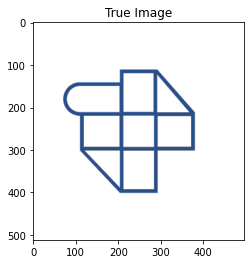

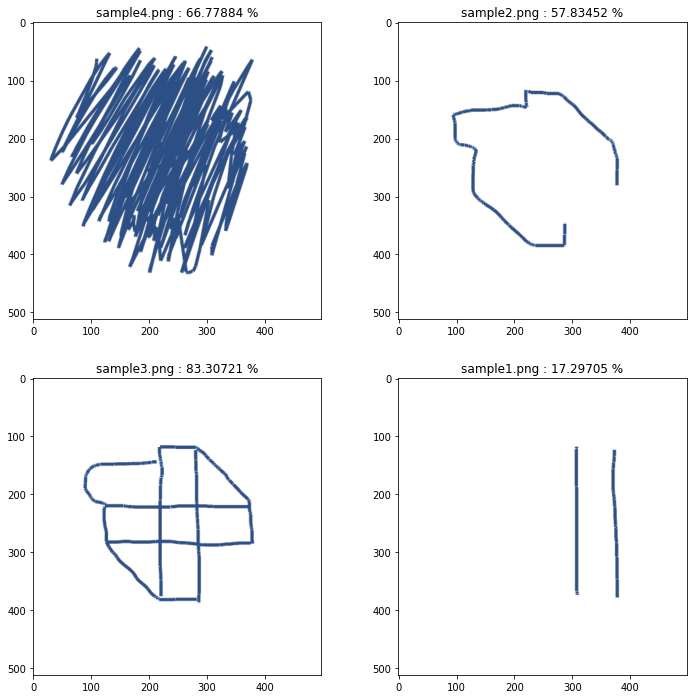

<Figure size 432x288 with 0 Axes>

In [44]:
distances = []
for i in range(num_images):
    distances.append(cosine(embedding_true, flattened_embedding[i]))

imgs = ['/content/image_similarity_examples/sample4.png',
'/content/image_similarity_examples/sample2.png',
'/content/image_similarity_examples/sample3.png',
'/content/image_similarity_examples/sample1.png']

# normalize the array
d = np.asarray(distances)
norm = np.linalg.norm(d)
normal_array = d/norm

# similarity
similarities = (1 - normal_array) * 100

# show true image
im = Image.open('true_img.png')
plt.title("True Image")
imgplot = plt.imshow(im)
plt.show()

# plot the images with scores
_, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()

for img_path, ax, s in zip(imgs, axs, similarities):
	name = img_path.split('/')[-1]

	im = Image.open(img_path)
	ax.set_title("{} : {:.5f} %".format(name, s))
	ax.imshow(im)
	

plt.savefig("result_similarity_image.jpg")
plt.show()